In [11]:
import networkx as nx
from ipysigma import Sigma
from utils import load_graph_v3, load_graph_v3_rustworkx
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nx_parallel as nxp
import rustworkx as rx

In [23]:
PATH_TO_GRAPH = "spotify_graph_l0renzz_5.jsonl"

In [24]:
R, id_map = load_graph_v3_rustworkx(PATH_TO_GRAPH)

In [25]:

G = load_graph_v3(PATH_TO_GRAPH)
G_undirected = G.to_undirected()


In [26]:
#count lines aka number of users originally scraped
with open("checkpoint_l0renzz.json", "r") as f:
    num_lines = sum(1 for _ in f)
print(num_lines)

1649433


In [27]:

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Rustworkx Nodes: {len(R.nodes())}, Edges: {len(R.edges())}")

Nodes: 1027784, Edges: 4649217
Rustworkx Nodes: 1027784, Edges: 5496130


nNumber of Users with 0 followers: 36355


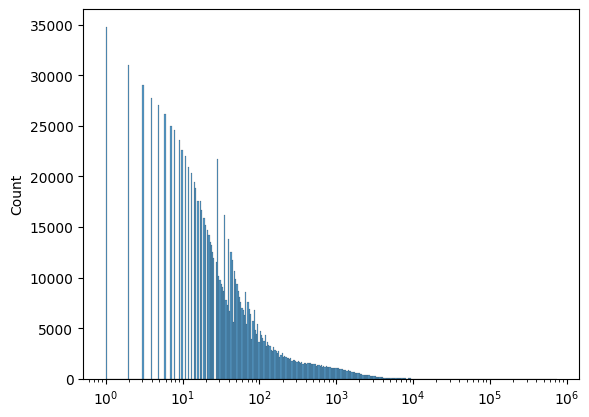

In [32]:
user_indegree_series = pd.Series({node: data if data is not None else 0 for node, data in G.nodes(data='followers_count')})
sns.histplot(user_indegree_series, log_scale=True)
print("nNumber of Users with 0 followers:", (user_indegree_series == 0).sum())

In [35]:
#print example users with highest indegree
top_users = user_indegree_series.sort_values(ascending=False).head(10)
top_users_out_vs_indegree = {}
for user_id in top_users.index:
    out_degree = G.out_degree(user_id)
    in_degree = G.in_degree(user_id)
    top_users_out_vs_indegree[user_id] = (out_degree, in_degree)
print("Top 10 users by followers count:")
for user_id, followers_count in top_users.items():
    print(f"User ID: {user_id}, Followers Count: {followers_count}")
    print(f"    Out-degree (following): {top_users_out_vs_indegree[user_id][0]}, In-degree (followers): {top_users_out_vs_indegree[user_id][1]}")

Top 10 users by followers count:
User ID: myplay.com, Followers Count: 736428
    Out-degree (following): 1, In-degree (followers): 0
User ID: coca-cola, Followers Count: 712690
    Out-degree (following): 1, In-degree (followers): 0
User ID: napstersean, Followers Count: 504002
    Out-degree (following): 1, In-degree (followers): 0
User ID: mejoreslistasspotify, Followers Count: 246284
    Out-degree (following): 1, In-degree (followers): 0
User ID: cl4pu66mupttwuzei265gpsjf, Followers Count: 211785
    Out-degree (following): 1, In-degree (followers): 0
User ID: capitolrecords, Followers Count: 202860
    Out-degree (following): 1, In-degree (followers): 0
User ID: 12100249023, Followers Count: 194237
    Out-degree (following): 9648, In-degree (followers): 1000
User ID: sharemyplaylists.com, Followers Count: 107705
    Out-degree (following): 3, In-degree (followers): 0
User ID: numerogroup, Followers Count: 96841
    Out-degree (following): 1, In-degree (followers): 0
User ID: 223

In [33]:
#for bins of 10^0, 10^1, ..., 10^6, calculate the average proportion of followers in the node info, vs the indegree
bins = [10**i for i in range(7)]
proportions = []
for i in range(len(bins)-1):
    bin_lower = bins[i]
    bin_upper = bins[i+1]
    bin_nodes = [node for node, data in G.nodes(data='followers_count') if data is not None and bin_lower <= data < bin_upper]
    if len(bin_nodes) == 0:
        continue
    total_followers_count = sum(G.nodes[node]['followers_count'] for node in bin_nodes)
    total_indegree = sum(G.in_degree(node) for node in bin_nodes)
    proportion = total_indegree / total_followers_count if total_followers_count > 0 else 0
    proportions.append((f"{bin_lower}-{bin_upper}", proportion))

In [34]:
#print the proportions
print("Proportion of indegree to followers count by bins:")
for bin_range, proportion in proportions:
    print(f"Bin {bin_range}: Proportion {proportion:.4f}")

Proportion of indegree to followers count by bins:
Bin 1-10: Proportion 0.0505
Bin 10-100: Proportion 0.0386
Bin 100-1000: Proportion 0.0323
Bin 1000-10000: Proportion 0.0589
Bin 10000-100000: Proportion 0.0168
Bin 100000-1000000: Proportion 0.0003


In [19]:
max_degree = 100
core = G.subgraph([n for n in G.nodes if G.degree(n) <= max_degree]).copy()
print(f"Core graph: {core.number_of_nodes()} nodes, {core.number_of_edges()} edges")

Core graph: 767992 nodes, 486644 edges


In [31]:
node_id = '317injtlhkbydpiw5xce3h6klnxi'

if G.has_node(node_id):
  in_degree = G.in_degree(node_id)
  out_degree = G.out_degree(node_id)
  print(f"Node '{node_id}':")
  print(f"  In-degree (followers): {in_degree}")
  print(f"  Out-degree (following): {out_degree}")
else:
  print(f"Node '{node_id}' not found in the graph.")

Node '317injtlhkbydpiw5xce3h6klnxi':
  In-degree (followers): 0
  Out-degree (following): 192


# Calculating base measures

## Degree

In [6]:
degrees = [d for n, d in G.degree()]
d_max = max(degrees)                  # d_max
d_avg = np.mean(degrees)
print(d_avg, d_max)

10.700809732712457 8457


## Clustering

In [20]:
transitivity = rx.digraph_transitivity(R)

In [21]:
print(transitivity)

0.04616888620268567


## Density

In [16]:
density = nx.density(G)
print(f"Density: {density:.6f}")

Density: 0.000018


## Transitivity

In [17]:
transitivity = nxp.betweenness_centrality(G)
print(f"Transitivity: {transitivity:.6f}")

Transitivity: 0.088134


## Centrality

In [ ]:
betweeness_centrality = rx.digraph_betweenness_centrality(R)
#closeness_centrality = nx.closeness_centrality(G)
print("Computed betweenness and closeness centrality:")
print(betweeness_centrality)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [38]:
# Set the backend to parallel for this computation
nx.set_backend("parallel")

# If successful, NetworkX may log the dispatching event depending on your log level
# For a directed graph, we should use weakly_connected_components
result = nx.weakly_connected_components(G)
print(f"Number of weakly connected components: {len(list(result))}")

# It's good practice to reset the backend to default if you don't need it for subsequent cells
nx.set_backend("sequential")

AttributeError: module 'networkx' has no attribute 'set_backend'

In [12]:
# Skip those nodes who presumably don't follow anyone
G_without_users_who_are_not_followed = G.subgraph([n for n in G.nodes if G.in_degree(n) > 0]).copy()
reciprocity = nx.reciprocity(G_without_users_who_are_not_followed)
print(f"Reciprocity: {reciprocity:.4f}")

Reciprocity: 0.2439
